# LIBRARIES

In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy

# DATASET PREPARATION & CONFIGURATION

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
data_dir = "C:/Users/USER/Documents/project P/glaucoma_dataset"
batch_size = 16
img_size = 224
num_classes = 2
num_epochs = 30
learning_rate = 3e-4
patience = 5  # early stopping

# Image transforms
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


# DATASET LOADING & SPLITTING

In [3]:
# Dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes

# Split into train/val/test (80/10/10)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size)
test_loader = DataLoader(test_ds, batch_size=batch_size)


# MODEL TRAINING & OPTIMIZATION

In [4]:
# Load pretrained Vision Transformer (ViT)
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

# Early stopping setup
best_model_wts = copy.deepcopy(model.state_dict())
best_val_loss = float('inf')
no_improve_epochs = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")



Epoch 1/30

Epoch 2/30

Epoch 3/30

Epoch 4/30

Epoch 5/30

Epoch 6/30

Epoch 7/30

Epoch 8/30

Epoch 9/30

Epoch 10/30

Epoch 11/30

Epoch 12/30

Epoch 13/30

Epoch 14/30

Epoch 15/30

Epoch 16/30

Epoch 17/30

Epoch 18/30

Epoch 19/30

Epoch 20/30

Epoch 21/30

Epoch 22/30

Epoch 23/30

Epoch 24/30

Epoch 25/30

Epoch 26/30

Epoch 27/30

Epoch 28/30

Epoch 29/30

Epoch 30/30


# TRAINING LOOP IMPLEMENTATION

In [5]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # --- Training phase ---
    model.train()
    running_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Train Loss: {avg_train_loss:.4f}")

    # --- Validation phase ---
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

    # --- Early stopping check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
        torch.save(model.state_dict(), "best_vit_fundus_model.pth")
        print("✅ Model improved and saved.")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print("⛔ Early stopping triggered.")
            break

# Load best model weights after training
model.load_state_dict(best_model_wts)



Epoch 1/30
Train Loss: 0.7872
Validation Loss: 0.5451, Accuracy: 0.6752
✅ Model improved and saved.

Epoch 2/30
Train Loss: 0.5131
Validation Loss: 0.4568, Accuracy: 0.7863
✅ Model improved and saved.

Epoch 3/30
Train Loss: 0.5336
Validation Loss: 0.4986, Accuracy: 0.7521

Epoch 4/30
Train Loss: 0.5173
Validation Loss: 0.5432, Accuracy: 0.7863

Epoch 5/30
Train Loss: 0.5332
Validation Loss: 0.4569, Accuracy: 0.7692

Epoch 6/30
Train Loss: 0.4477
Validation Loss: 0.4498, Accuracy: 0.7949
✅ Model improved and saved.

Epoch 7/30
Train Loss: 0.4452
Validation Loss: 0.4375, Accuracy: 0.7863
✅ Model improved and saved.

Epoch 8/30
Train Loss: 0.4506
Validation Loss: 0.4398, Accuracy: 0.7863

Epoch 9/30
Train Loss: 0.4495
Validation Loss: 0.4661, Accuracy: 0.7863

Epoch 10/30
Train Loss: 0.4396
Validation Loss: 0.4423, Accuracy: 0.7863

Epoch 11/30
Train Loss: 0.4329
Validation Loss: 0.4307, Accuracy: 0.7949
✅ Model improved and saved.

Epoch 12/30
Train Loss: 0.4316
Validation Loss: 0.4195

<All keys matched successfully>

# MODEL EVALUATION & PERFORMANCE METRICS


 Final Test Accuracy: 0.7966

 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        51
           1       0.77      0.93      0.84        67

    accuracy                           0.80       118
   macro avg       0.82      0.78      0.78       118
weighted avg       0.81      0.80      0.79       118



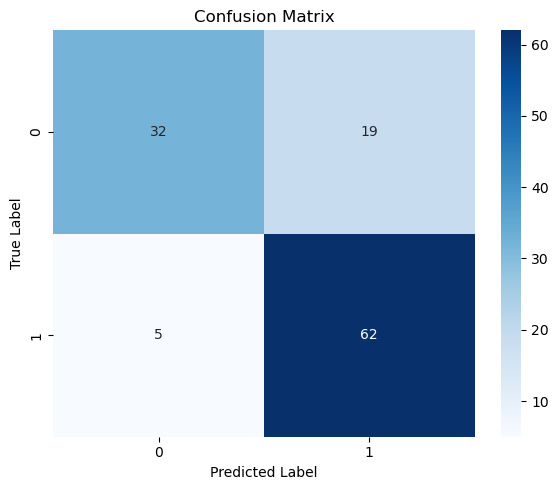

In [11]:
# --- Test Evaluation ---
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1).cpu()
        test_preds.extend(preds)
        test_labels.extend(labels)

test_acc = accuracy_score(test_labels, test_preds)
print(f"\n Final Test Accuracy: {test_acc:.4f}")

# --- Confusion Matrix & Report ---
cm = confusion_matrix(test_labels, test_preds)
report = classification_report(test_labels, test_preds, target_names=class_names)

print("\n Classification Report:")
print(report)

# --- Confusion matrix plot ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# TRAINING HISTORY VISUALIZATION

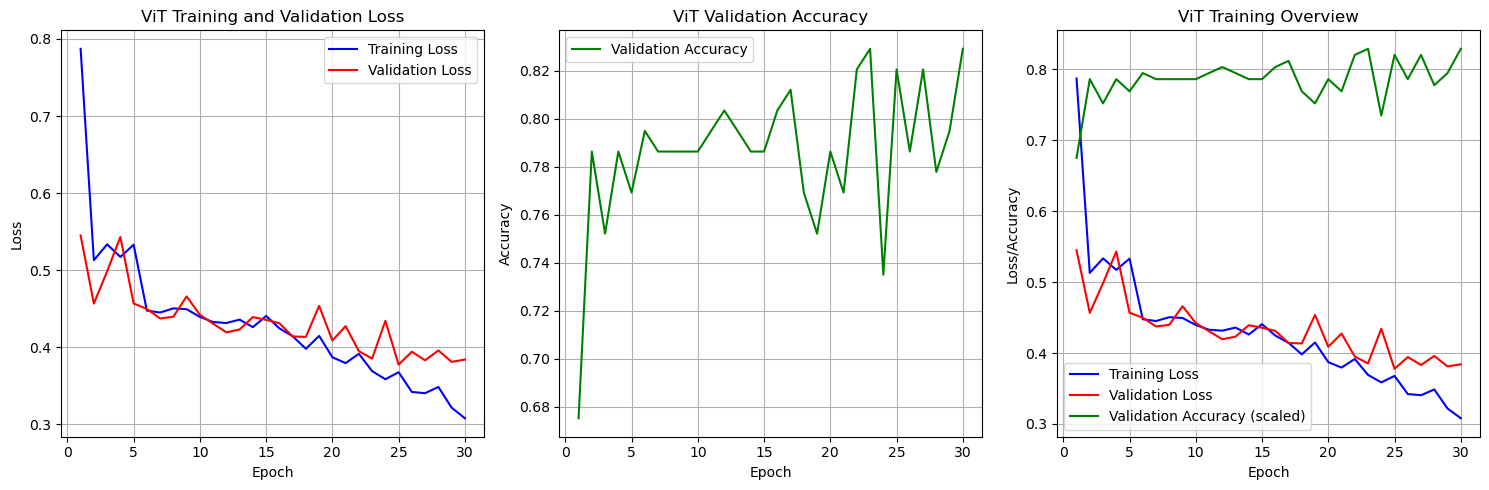

In [9]:
train_losses = [0.7872, 0.5131, 0.5336, 0.5173, 0.5332, 0.4477, 0.4452, 0.4506, 0.4495, 0.4396, 
                0.4329, 0.4316, 0.4360, 0.4262, 0.4408, 0.4247, 0.4145, 0.3982, 0.4149, 0.3872, 
                0.3796, 0.3917, 0.3692, 0.3587, 0.3678, 0.3422, 0.3406, 0.3487, 0.3218, 0.3081]

val_losses = [0.5451, 0.4568, 0.4986, 0.5432, 0.4569, 0.4498, 0.4375, 0.4398, 0.4661, 0.4423, 
              0.4307, 0.4195, 0.4232, 0.4393, 0.4357, 0.4313, 0.4142, 0.4136, 0.4538, 0.4089, 
              0.4275, 0.3951, 0.3854, 0.4344, 0.3777, 0.3944, 0.3832, 0.3960, 0.3812, 0.3842]

val_accuracies = [0.6752, 0.7863, 0.7521, 0.7863, 0.7692, 0.7949, 0.7863, 0.7863, 0.7863, 0.7863, 
                  0.7949, 0.8034, 0.7949, 0.7863, 0.7863, 0.8034, 0.8120, 0.7692, 0.7521, 0.7863, 
                  0.7692, 0.8205, 0.8291, 0.7350, 0.8205, 0.7863, 0.8205, 0.7778, 0.7949, 0.8291]

# Plot the training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 31), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, 31), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ViT Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, 31), val_accuracies, 'g-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ViT Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
epochs = range(1, 31)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy (scaled)')
plt.xlabel('Epoch')
plt.ylabel('Loss/Accuracy')
plt.title('ViT Training Overview')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()